## Differentiating the measures of risk

Let's explore different measures of risk. We will use the trading performance from the volatility adjusted mean reversion strategy we saw in Chapter 5, Sophisticated Algorithmic Strategies, as an example of a trading strategy in which we wish to understand the risks behind and quantify and calibrate them.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
results = pd.read_csv('src/Chapter6/volatility_adjusted_mean_reversion.csv')
results.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,ClosePrice,Fast10DayEMA,Slow40DayEMA,APO,Trades,Position,Pnl
0,2014-01-02,555.647278,556.788025,552.06073,554.481689,554.481689,3656400,554.481689,554.481689,554.481689,0.0,0,0,0.0


For the purposes of implementing and quantifying risk measures, the fields we are interested in are Date, High, Low, ClosePrice, Trades, Position, and PnL. We will ignore the other fields since we do not require them for the risk measures we are currently interested in. Now, let's dive into understanding and implementing our risk measures.

### Stop-loss

The first risk limit we will look at is quite intuitive and is called **stop-loss**, or **max-loss**. This limit is the maximum amount of money a strategy is allowed to lose, that is, the minimum PnL allowed. This often has a notion of a time frame for that loss, meaning stop-loss can be for a day, for a week, for a month, or for the entire lifetime of the strategy. A stop-loss with a time frame of a day means that if the strategy loses a stop-loss amount of money in a single day, it is not allowed to trade any more on that day, but can resume the next day. Similarly, for a stop-loss amount in a week, it is not allowed to trade anymore for that week, but can resume next week.

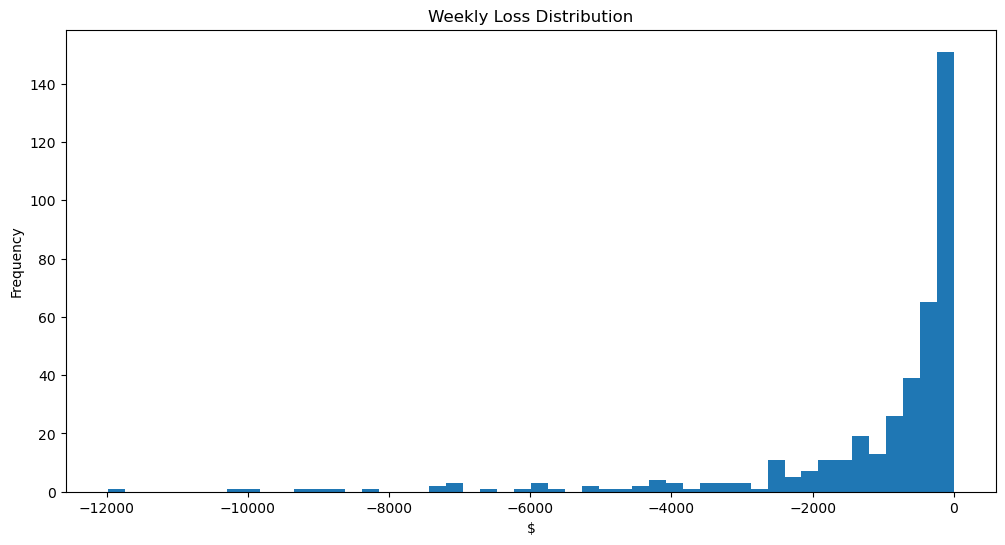

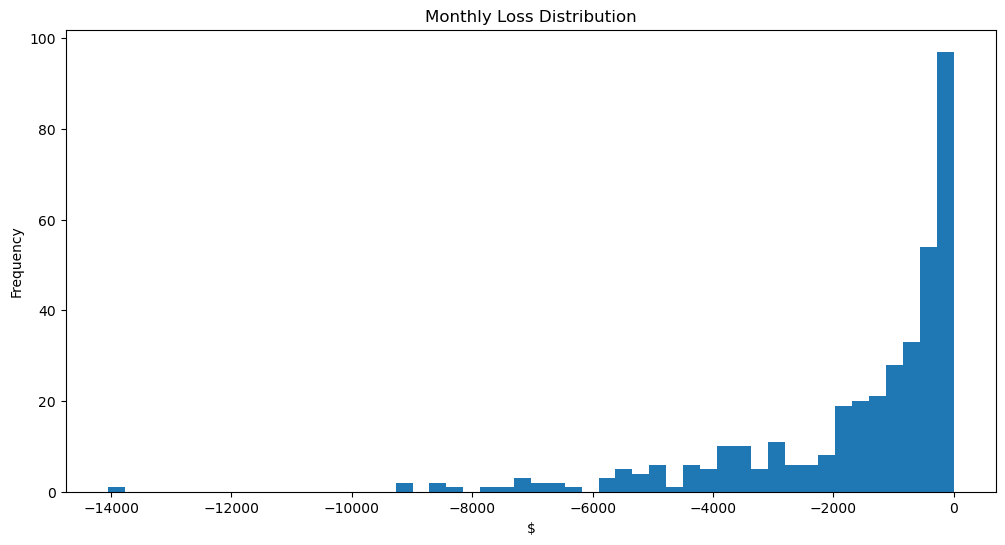

In [3]:
num_days = len(results.index)

pnl = results['Pnl']

weekly_losses = []
monthly_losses = []

for i in range(0, num_days):
    if i >= 5 and pnl[i - 5] > pnl[i]:
        weekly_losses.append(pnl[i] - pnl[i - 5])

    if i >= 20 and pnl[i - 20] > pnl[i]:
        monthly_losses.append(pnl[i] - pnl[i - 20])

plt.figure(figsize=(12, 6))
plt.hist(weekly_losses, 50)
plt.gca().set(title='Weekly Loss Distribution', xlabel='$', ylabel='Frequency')
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(monthly_losses, 50)
plt.gca().set(title='Monthly Loss Distribution', xlabel='$', ylabel='Frequency')
plt.show()

The plots show the distribution of weekly and monthly losses. From these, we can observe the following:

* A weekly loss of anything more than \$4K and a monthly loss of anything more than \\$6K is highly unexpected.
* A weekly loss of more than \$12K and a monthly loss of \\$14K have never happened, so it can be considered an unprecedented event, but we will revisit this later.

### Max drawdown

**Max drawdown** is also a PnL metric, but this measures the maximum loss that a strategy can take over a series of days. This is defined as the peak to trough decline in a trading strategy's account value. This is important as a risk measure so that we can get an idea of what the historical maximum decline in the account value can be. This is important because we can get unlucky during the deployment of a trading strategy and run it in live markets right at the beginning of the drawdown.

Having an expectation of what the maximum drawdown is can help us understand whether the strategy loss streak is still within our expectations or whether something unprecedented is happening. Let's look at how to compute it:

Max Drawdown: 15340.41716347829


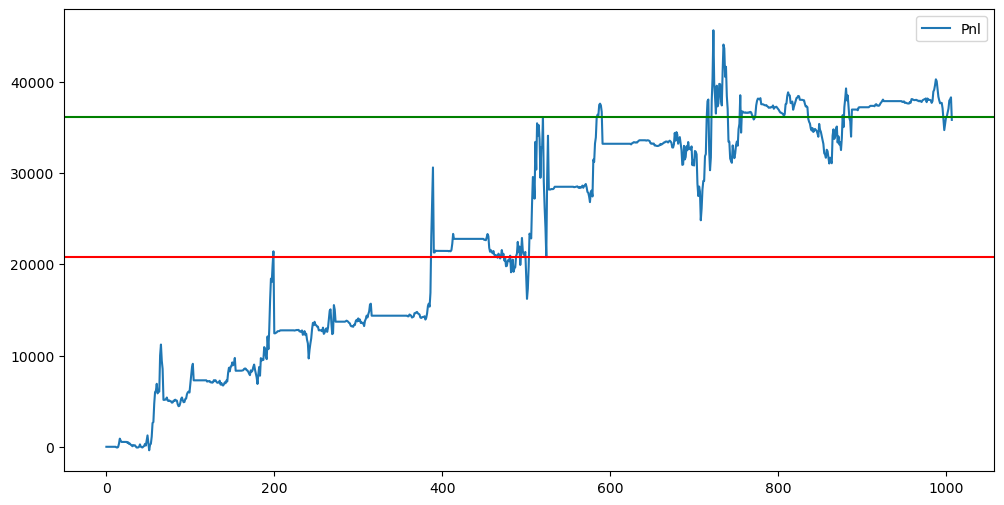

In [4]:
max_pnl = 0
max_drawdown = 0
drawdown_max_pnl = 0
drawdown_min_pnl = 0

for i in range(0, num_days):
    max_pnl = max(max_pnl, pnl[i])
    drawdown = max_pnl - pnl[i]

    if drawdown > max_drawdown:
        max_drawdown = drawdown
        drawdown_max_pnl = max_pnl
        drawdown_min_pnl = pnl[i]

print('Max Drawdown:', max_drawdown)

plt.figure(figsize=(12, 6))
results['Pnl'].plot(x='Date', legend=True)
plt.axhline(y=drawdown_max_pnl, color='g')
plt.axhline(y=drawdown_min_pnl, color='r')
plt.show()

In the plot, the max drawdown occurs roughly during the middle of this PnL series, with the maximum PnL being 37K and the minimum PnL after that high being 22K, causing the maximum drawdown achieved to be roughly 15K.

### Position limits

**Position limits** are also quite straightforward and intuitive to understand. It is simply the maximum position, long or short, that the strategy should have at any point in its trading lifetime. It is possible to have two different position limits, one for the maximum long position and another for the maximum short position, which can be useful, for instance, where shorting stocks have different rules/risks associated with them than being long on stocks does. Every unit of open position has a risk associated with it. Generally, the larger the position a strategy puts on, the larger the risk associated with it. So, the best strategies are the ones that can make money while getting into as small a position as possible. In either case, before a strategy is deployed to production, it is important to quantify and estimate what the maximum positions the strategy can get into, based on historical performance, so that we can find out when a strategy is within its normal behavior parameters and when it is outside of historical norms.

Finding the maximum position is straightforward. Let's find a quick distribution of the positions with the help of the following code:

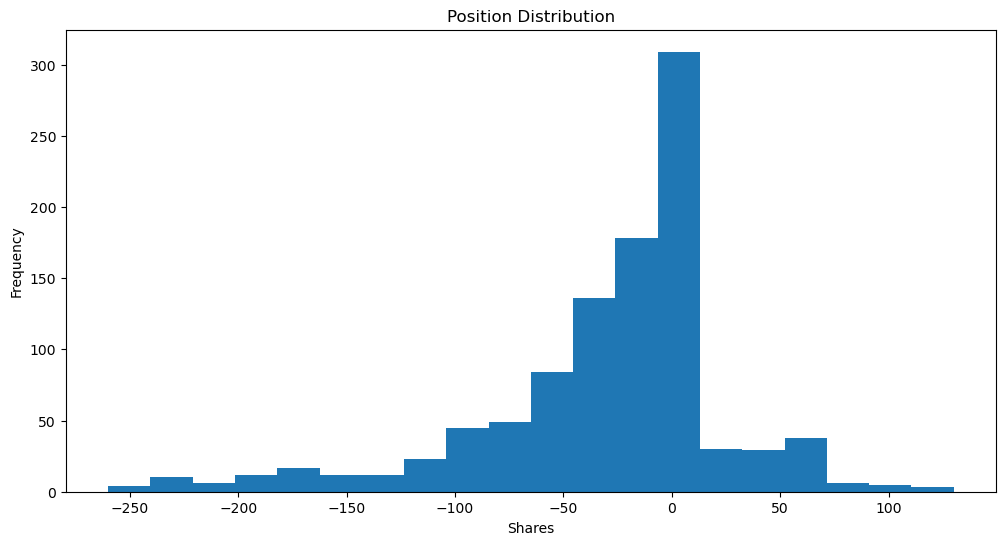

In [5]:
position = results['Position']
plt.figure(figsize=(12, 6))
plt.hist(position, 20)
plt.gca().set(title='Position Distribution', xlabel='Shares', ylabel='Frequency')
plt.show()

We can see the following from the preceding chart:
* For this trading strategy, which has been applied to Google stock data, the strategy is unlikely to have a position exceeding 200 shares and has never had a position exceeding 250.
* If it gets into position levels exceeding 250, we should be careful that the trading strategy is still performing as expected.

### Position holding time

While analyzing positions that a trading strategy gets into, it is also important to measure how long a position stays open until it is closed and returned to its flat position or opposition position. The longer a position stays open, the more risk it is taking on, because the more time there is for markets to make massive moves that can potentially go against the open position. A long position is initiated when the position goes from being short or flat to being long and is closed when the position goes back to flat or short. Similarly, short positions are initiated when the position goes from being long or flat to being short and is closed when the position goes back to flat or long.

Now, let's find the distribution of open position durations with the help of the following code:

[7, 44, 35, 36, 40, 3, 3, 50, 32, 32, 2, 8, 78, 5, 36, 4, 6, 115, 22, 45, 61, 3, 3, 12, 15, 16]


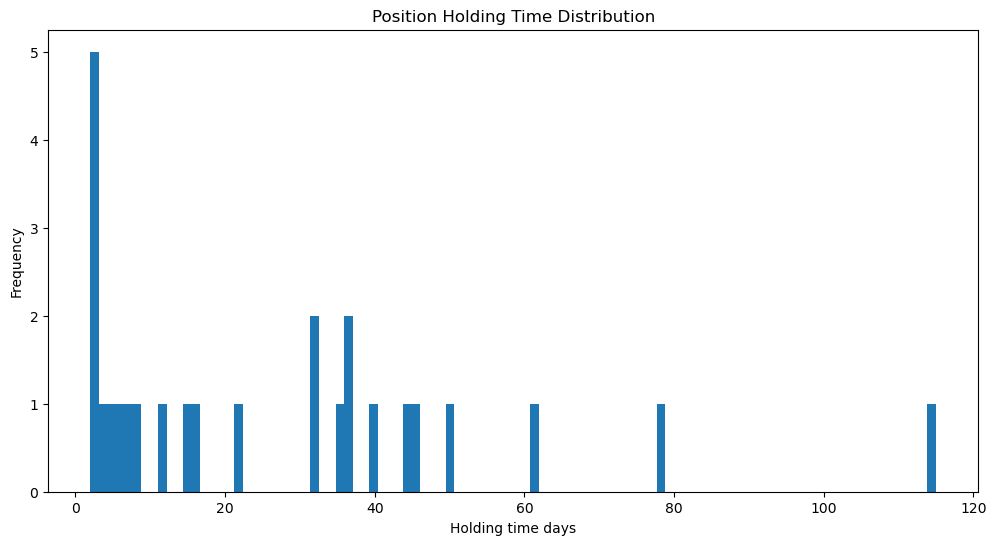

In [6]:
position_holding_times = []
current_pos = 0
current_pos_start = 0
for i in range(0, num_days):
    pos = results['Position'].iloc[i]

    # flat and starting a new position
    if current_pos == 0:
        if pos != 0:
            current_pos = pos
            current_pos_start = i
        continue

    # going from long position to flat or short position or
    # going from short position to flat or long position
    if current_pos * pos <= 0:
        current_pos = pos
        position_holding_times.append(i - current_pos_start)
        current_pos_start = i

print(position_holding_times)
plt.figure(figsize=(12, 6))
plt.hist(position_holding_times, 100)
plt.gca().set(title='Position Holding Time Distribution', xlabel='Holding time days', ylabel='Frequency')
plt.show()

So, for this strategy, we can see that the holding time is pretty distributed, with the longest one lasting around 115 days and the shortest one lasting around 3 days.

### Variance of PnLs

We need to measure how much the PnLs can vary from day to day or even week to week. This is an important measure of risk because if a trading strategy has large swings in PnLs, the account value is very volatile and it is hard to run a trading strategy with such a profile. Often, we compute the Standard Deviation of returns over different days or weeks or whatever timeframe we choose to use as our investment time horizon. Most optimization methods try to find optimal trading performance as a balance between PnLs and the Standard Deviation of returns.

Computing the standard deviation of returns is easy. Let's compute the standard deviation of weekly returns, as shown in the following code:

PnL Standard Deviation: 1995.183472700812


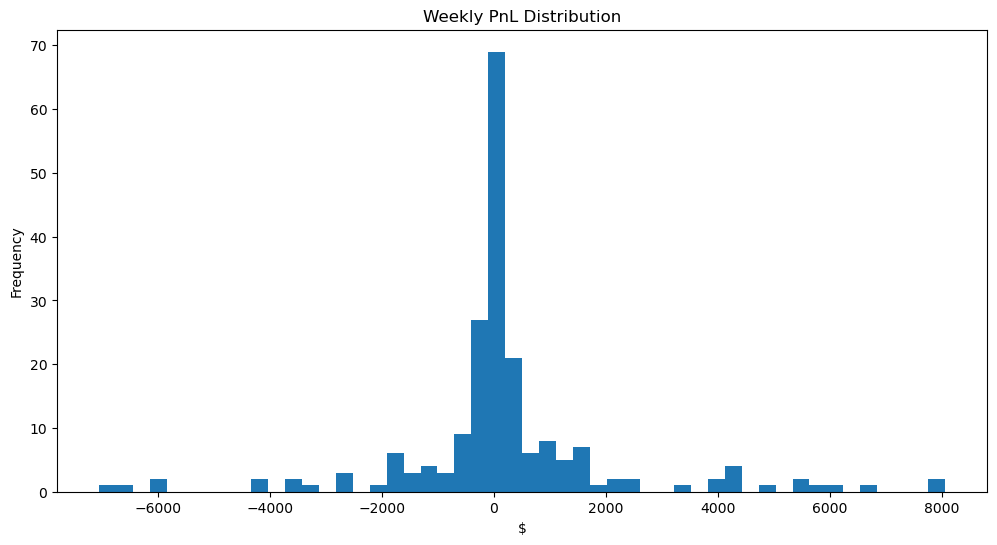

In [7]:
last_week = 0
weekly_pnls = []
weekly_losses = []
for i in range(0, num_days):
    if i - last_week >= 5:
        pnl_change = pnl[i] - pnl[last_week]
        weekly_pnls.append(pnl_change)
        if pnl_change < 0:
            weekly_losses.append(pnl_change)
        last_week = i

from statistics import stdev, mean
print('PnL Standard Deviation:', stdev(weekly_pnls))

plt.figure(figsize=(12, 6))
plt.hist(weekly_pnls, 50)
plt.gca().set(title='Weekly PnL Distribution', xlabel='$', ylabel='Frequency')
plt.show()

We can see that the weekly PnLs are close to being normally distributed around a mean of $0, which intuitively makes sense. The distribution is right skewed, which yields the positive cumulative PnLs for this trading strategy. There are some very large profits and losses for some weeks, but they are very rare, which is also within the expectations of what the distribution should look like.

### Sharpe ratio

**Sharpe ratio** is a very commonly used performance and risk metric that's used in the industry to measure and compare the performance of algorithmic trading strategies. Sharpe ratio is defined as the ratio of average PnL over a period of time and the PnL standard deviation over the same period. The benefit of the Sharpe ratio is that it captures the profitability of a trading strategy while also accounting for the risk by using the volatility of the returns. Let's have a look at the mathematical representation:

$$
Sharpe Ratio = \cfrac{Avg Daily PnL}{Standard Deviation Of Daily Pnls}
$$

$$
Avg Daily PnL = \cfrac{\sum_{i=1}^NPnl_i}{N}
$$

$$
Standard Deviation Of Daily Pnls = \cfrac{\sum_{i=1}^N(Pnl_i-Avg Daily PnL)^2}{N}
$$

Here, we have the following:

* $Pnl_i$: PnL on the $i^{th}$ trading day.
* N: Number of trading days over which this Sharpe is being computed.

Another performance and risk measure similar to the Sharpe ratio is known as the Sortino ratio, which only uses observations where the trading strategy loses money and ignores the ones where the trading strategy makes money. The simple idea is that, for a trading strategy, Sharpe upside moves in PnLs are a good thing, so they should not be considered when computing the standard deviation. Another way to say the same thing would be that only downside moves or losses are actual risk observations.

Let's compute the Sharpe and Sortino ratios for our trading strategy. We will use a week as the time horizon for our trading strategy:

In [8]:
sharpe_ratio = mean(weekly_pnls) / stdev(weekly_pnls)
sortino_ratio = mean(weekly_pnls) / stdev(weekly_losses)

print('Sharpe ratio:', sharpe_ratio)
print('Sortino ratio:', sortino_ratio)

Sharpe ratio: 0.0949474806558361
Sortino ratio: 0.11925614548156241


Here, we can see that the Sharpe ratio and the Sortino ratio are close to each other, which is what we expect since both are risk-adjusted return metrics. The Sortino ratio is slightly higher than the Sharpe ratio, which also makes sense since, by definition, the Sortino ratio does not consider large increases in PnLs as being contributions to the drawdown/risk for the trading strategy, indicating that the Sharpe ratio was, in fact, penalizing some large +ve jumps in PnLs.

### Maximum executions per period

This risk measure is an interval-based risk check. An interval-based risk is a counter that resets after a fixed amount of time and the risk check is imposed within such a time slice. So, while there is no final limit, it's important that the limit isn't exceeded within the time interval that is meant to detect and avoid over-trading. The interval-based risk measure we will inspect is maximum executions per period. This measures the maximum number of trades allowed in a given timeframe. Then, at the end of the timeframe, the counter is reset and starts over. This would detect and prevent a runaway strategy that buys and sells at a very fast pace.

Let's look at the distribution of executions per period for our strategy using a week as our timeframe, as shown here:

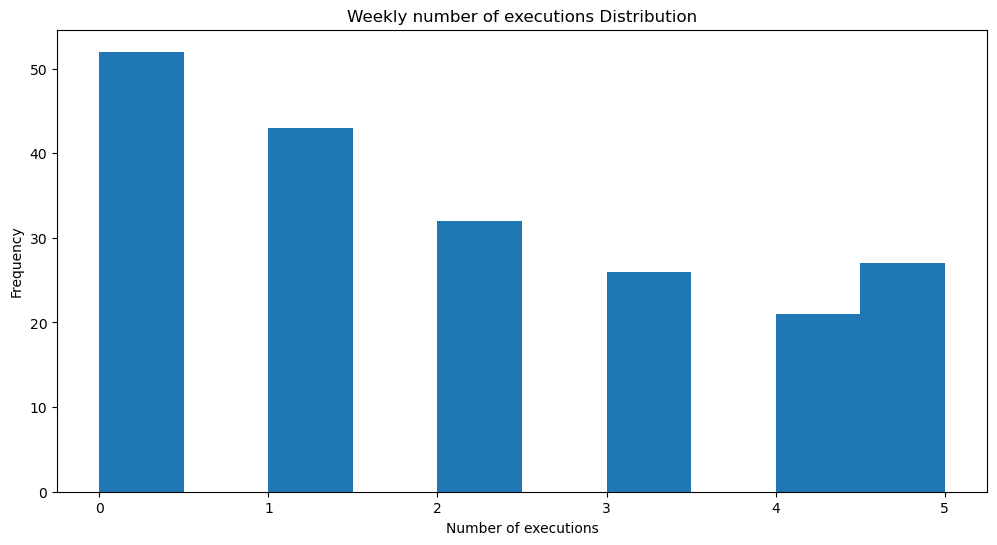

In [9]:
executions_this_week = 0
executions_per_week = []
last_week = 0
for i in range(0, num_days):
    if results['Trades'].iloc[i] != 0:
        executions_this_week += 1

    if i - last_week >= 5:
        executions_per_week.append(executions_this_week)
        executions_this_week = 0
        last_week = i

plt.figure(figsize=(12, 6))
plt.hist(executions_per_week, 10)
plt.gca().set(title='Weekly number of executions Distribution', xlabel='Number of executions', ylabel='Frequency')
plt.show()

As we can see, for this trading strategy, it's never traded more than five times a week in the past, which is when it trades every day of the week, which doesn't help us much. Now, let's look at the maximum executions per month:

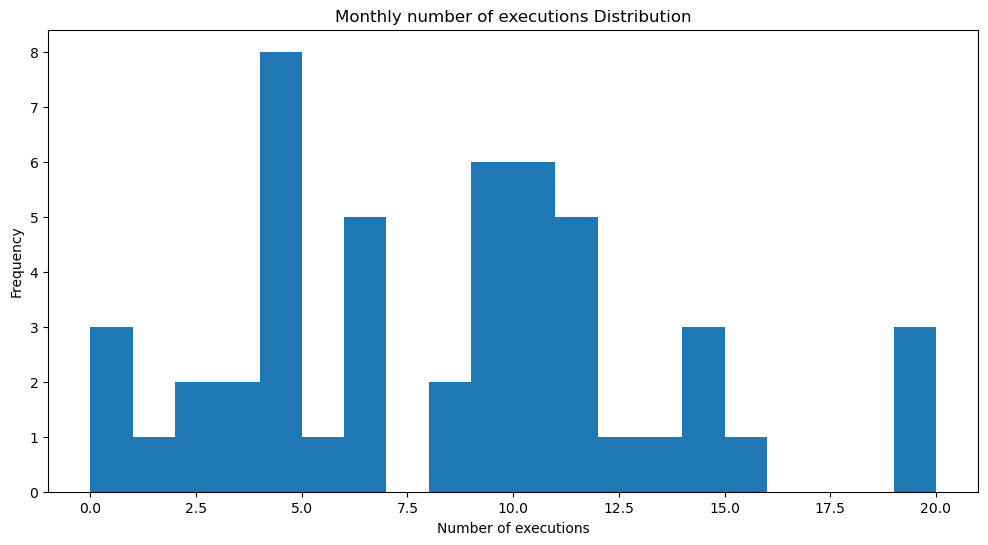

In [10]:
executions_this_month = 0
executions_per_month = []
last_month = 0
for i in range(0, num_days):
    if results['Trades'].iloc[i] != 0:
        executions_this_month += 1

    if i - last_month >= 20:
        executions_per_month.append(executions_this_month)
        executions_this_month = 0
        last_month = i

plt.figure(figsize=(12, 6))
plt.hist(executions_per_month, 20)
plt.gca().set(title='Monthly number of executions Distribution', xlabel='Number of executions', ylabel='Frequency')
plt.show()

We can observe the following from the preceding plot:
* It is possible for the strategy to trade every day in a month, so this risk measure can't really be used for this strategy.
* However, this is still an important risk measure to understand and calibrate, especially for algorithmic trading strategies that trade frequently, and especially for HFT strategies.

### Maximum trade size

This risk metric measures what the maximum possible trade size for a single trade for the trading strategy is. In our previous examples, we use static trade sizes, but it is not very difficult to build a trading strategy that sends a larger order when the trading signal is stronger and a smaller order when the trading signal is weaker. Alternatively, a strategy can choose to liquidate a larger than normal position in one trade if it's profitable, in which case it will send out a pretty large order. This risk measure is also very helpful when the trading strategy is a gray box trading strategy as it prevents fat-finger errors, among other things. We will skip implementing this risk measure here, but all we do is find a distribution of per trade size, which should be straightforward to implement based on our implementation of previous risk measures.

### Volume limits

This risk metric measures the traded volume, which can also have an interval-based variant that measures volume per period. This is another risk measure that is meant to detect and prevent overtrading. For example, some of the catastrophic software implementation bugs we discussed in this chapter could've been prevented if they had a tight volume limit in place that warned operators about risk violations and possibly a volume limit that shut down trading strategies. Let's observe the traded volume for our strategy, which is shown in the following code:

In [11]:
traded_volume = 0
for i in range(0, num_days):
    if results['Trades'].iloc[i] != 0:
        traded_volume += abs(results['Position'].iloc[i] - results['Position'].iloc[i-1])

print('Total traded volume:', traded_volume)

Total traded volume: 4050


In this case, the strategy behavior is as expected, that is, no overtrading is detected. We can use this to calibrate what total traded volume to expect from this strategy when it is deployed to live markets. If it ever trades significantly more than what is expected, we can detect that to be an over-trading condition.

## Making a risk management algorithm

By now, we're aware of the different types of risks and factors, including the risks in a trading strategy and the most common risk metrics for algorithmic trading strategies. Now, let's have a look at incorporating these risk measures into our volatility adjusted mean reversion trading strategy to make it safer before deploying it into live markets. We will set the risk limits to 150% of the maximum achieved historically. We are doing this because it is possible that there is a day in the future that is very different from what we've seen historically. Let's get started:

In [12]:
import pandas as pd
from pandas_datareader import data

In [13]:
import yfinance as yf
yf.pdr_override()

In [14]:
# Fetch daily data for 4 years
SYMBOL = 'GOOG'
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = SYMBOL + '_data.pkl'

In [15]:
try:
    df = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
    # df = data.DataReader(SYMBOL, 'yahoo', start_date, end_date)
    df = data.get_data_yahoo(SYMBOL, start=start_date, end=end_date)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,555.647278,556.788025,552.060730,554.481689,554.481689,3656400
2014-01-03,555.418152,556.379578,550.401978,550.436829,550.436829,3345800
2014-01-06,554.426880,557.340942,551.154114,556.573853,556.573853,3551800
2014-01-07,560.399475,567.717041,558.486633,567.303589,567.303589,5124300
2014-01-08,570.860291,571.517822,564.528992,568.484192,568.484192,4501700
...,...,...,...,...,...,...
2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600
2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900
2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100
